# Image Segmentation

## Imports

In [ ]:
import tensorflow as tf
import pathlib
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
from functools import partial
from tqdm import tqdm_notebook as tqdm

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-spe8e5iw
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-spe8e5iw
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 4.8MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33791 sha256=e7352339a4fbbc2fd5e9990123ad9eba7f07aed7acc834a1a1777fe1239e2fa5
  Stored in directory: /tmp/pip-ephem-wheel-cache-pvjskhus/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-7um4aoqb
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-7um4aoqb
     |████████████████████████████████| 952kB 10.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.5.0-cp36-none-any.whl size=70569 sha256=79861177dff368bff23c41720dedaa756315f4b7ac217a7505240813e538649c
  Stored in directory: /tmp/pip-ephem-wheel-cache-g7rdooyl/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import albumentations as A

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


## Dataset

In [ ]:
dataset_url ="https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz"

data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='camvid', 
                                   untar=True,
                                   cache_dir='/content/')

pathlib.Path('/content/datasets/camvid.tar.gz').unlink() 

598917120/598913237 [==============================] - 13s 0us/step


In [ ]:
data_dir = '/content/datasets/camvid/'
data_dir = pathlib.Path(data_dir)
images_list = (data_dir/'images').glob('*.png')
images_list = [str(x) for x in images_list]
np.random.shuffle(images_list)
valid_images_list = np.loadtxt('datasets/camvid/valid.txt',dtype='str')
valid_images_list = set(str(data_dir/'images'/x) for x in valid_images_list)
train_images_list = set(images_list).difference(valid_images_list)
train_images_list = list(train_images_list)
valid_images_list = list(valid_images_list)
print(len(train_images_list), 'Training images')
print(len(valid_images_list), 'validation images')

600 Training images
101 validation images


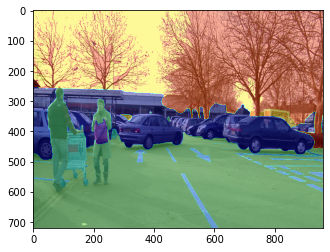

In [ ]:
img = PIL.Image.open(train_images_list[100])
plt.imshow(img)
img = PIL.Image.open(train_images_list[100].replace('images', 'labels').split('.png')[0]+'_P.png')
plt.imshow(img, cmap='jet', alpha=0.4)
plt.show()

In [ ]:
classes = np.loadtxt('datasets/camvid/codes.txt',dtype='str')
NCLASSES = len(classes)

In [ ]:
train_masks_list = [x.replace('images', 'labels').split('.png')[0]+'_P.png' for x in train_images_list]
valid_masls_list = [x.replace('images', 'labels').split('.png')[0]+'_P.png' for x in valid_images_list]

In [ ]:
data_train = tf.data.Dataset.from_tensor_slices((train_images_list, train_masks_list))
data_val = tf.data.Dataset.from_tensor_slices((valid_images_list, valid_masls_list))

In [ ]:
classes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## tf.data.Data

In [ ]:
BATCH_SIZE = 8
IMG_SIZE = (384, 480)

In [ ]:
transforms_train = A.Compose([
            A.Resize(IMG_SIZE[0], IMG_SIZE[1], p=1),
            A.HorizontalFlip(p=0.5),              
            A.RandomSizedCrop(min_max_height=(IMG_SIZE[0]//2, IMG_SIZE[0]), height=IMG_SIZE[0], width=IMG_SIZE[1],
                             w2h_ratio=720/960, p=0.5),
            A.GaussNoise(p=0.1),
            A.IAAPerspective(p=0.4),
            A.MotionBlur(blur_limit=3, p=0.4),
            A.OneOf([A.RandomBrightnessContrast(), A.HueSaturationValue()], p=0.7),
            A.CLAHE(p=0.5)
        ])

transforms_val = A.Compose([
            A.Resize(IMG_SIZE[0], IMG_SIZE[1], p=1)
        ])

BACKBONE = 'efficientnetb0'
preprocess_input = sm.get_preprocessing(BACKBONE)

def aug_fn(image, mask, train):
    data = {"image": image, "mask": mask}
    if train:
      data = transforms_train(**data)
    else:
      data = transforms_val(**data)
    aug_img = data["image"]
    aug_img = preprocess_input(aug_img) # Don't forget the preprocess function!
    return aug_img, data["mask"]

def parse(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=1)
    return image, mask

def process_data_train(image, mask):
    aug_img, aug_mask = tf.numpy_function(func=aug_fn, inp=[image, mask, True], 
                                Tout=[tf.float32, tf.uint8])
    aug_img.set_shape(IMG_SIZE+(3,))
    aug_mask = tf.squeeze(aug_mask)
    aug_mask = tf.one_hot(aug_mask,depth=NCLASSES)
    aug_mask.set_shape(IMG_SIZE+(NCLASSES,))
    return aug_img, aug_mask

def process_data_val(image, mask):
    aug_img, aug_mask = tf.numpy_function(func=aug_fn, inp=[image, mask, False], 
                                Tout=[tf.float32, tf.uint8])
    aug_img.set_shape(IMG_SIZE+(3,))
    aug_mask = tf.squeeze(aug_mask)
    aug_mask = tf.one_hot(aug_mask,depth=NCLASSES)
    aug_mask.set_shape(IMG_SIZE+(NCLASSES,))
    return aug_img, aug_mask

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

data_train = data_train.shuffle(buffer_size=BATCH_SIZE*4).map(parse, 
                  num_parallel_calls=AUTOTUNE).cache().map(process_data_train,
                  num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
data_val = data_val.map(parse, 
                  num_parallel_calls=AUTOTUNE).cache().map(process_data_val,
                  num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

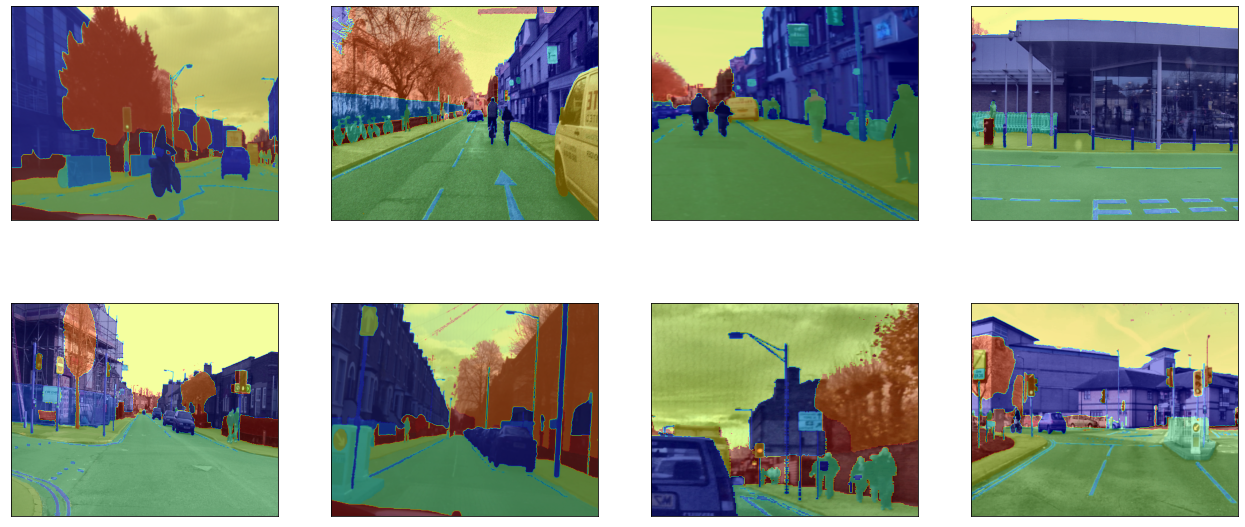

In [ ]:
def view_image_batch(ds, model=None):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image, mask = next(iter(ds)) # extract 1 batch from the dataset
    if model is None:
      mask = tf.argmax(mask,axis=-1)
    else:
      mask = tf.argmax(model(image),axis=-1)
    image = np.clip((image.numpy()*std)+mean,0,1) # Doing the efn.preprocess_input inverse 
    fig = plt.figure(figsize=(22, 10))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.imshow(mask[i], cmap='jet', alpha=0.4)

view_image_batch(data_train)

## U-Net

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
model = sm.Unet('efficientnetb0', input_shape=IMG_SHAPE, classes=NCLASSES, activation='softmax', decoder_block_type='transpose')

16809984/16804768 [==============================] - 1s 0us/step


In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
ckpt_path = pathlib.Path('/content/drive/My Drive/EECE 580G - DL4ECE/Materials/CNNs/checkpoints/')
os.makedirs(ckpt_path, exist_ok=True)
filepath = ckpt_path/'unet-transpose-medaug-efnb0-best'

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                   save_best_only=True,
                                                   monitor='val_accuracy', 
                                                   save_freq='epoch',
                                                   save_weights_only=True,
                                                   verbose=0)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=sm.losses.CategoricalFocalLoss(),
              metrics="accuracy")

history = model.fit(x=data_train, 
                    validation_data=data_val, 
                    callbacks=[ckpt_callback],
                    epochs=30)

Epoch 1/30
75/75 [==============================] - 50s 663ms/step - loss: 0.0040 - accuracy: 0.8088 - val_loss: 0.0033 - val_accuracy: 0.8529
Epoch 2/30
75/75 [==============================] - 48s 643ms/step - loss: 0.0043 - accuracy: 0.7953 - val_loss: 0.0030 - val_accuracy: 0.8540
Epoch 3/30
75/75 [==============================] - 48s 645ms/step - loss: 0.0036 - accuracy: 0.8219 - val_loss: 0.0021 - val_accuracy: 0.8738
Epoch 4/30
75/75 [==============================] - 49s 652ms/step - loss: 0.0037 - accuracy: 0.8179 - val_loss: 0.0021 - val_accuracy: 0.8752
Epoch 5/30
75/75 [==============================] - 49s 651ms/step - loss: 0.0035 - accuracy: 0.8263 - val_loss: 0.0020 - val_accuracy: 0.8832
Epoch 6/30
75/75 [==============================] - 48s 643ms/step - loss: 0.0034 - accuracy: 0.8323 - val_loss: 0.0024 - val_accuracy: 0.8834
Epoch 7/30
75/75 [==============================] - 48s 634ms/step - loss: 0.0034 - accuracy: 0.8297 - val_loss: 0.0019 - val_accuracy: 0.8802

In [ ]:
model.load_weights(filepath)

PREDICTED


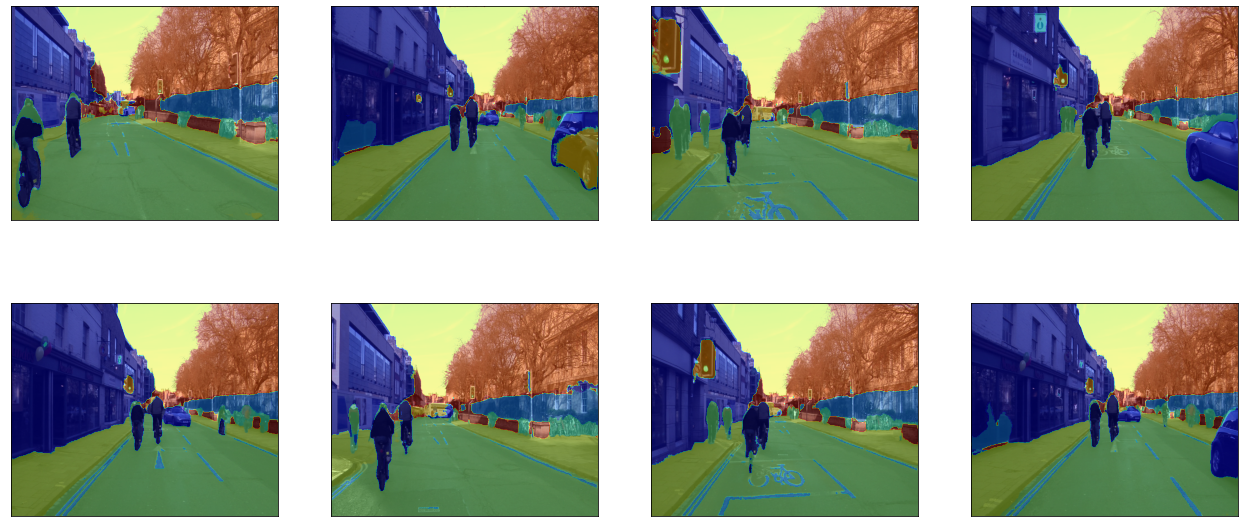

GROUND TRUTH


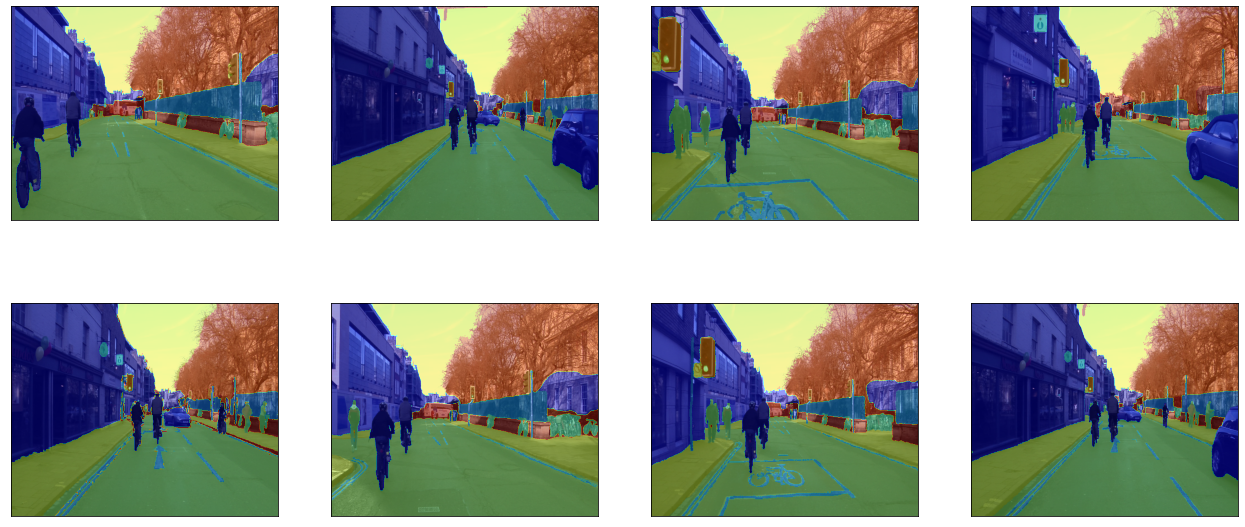

In [ ]:
print('PREDICTED')
view_image_batch(data_val, model)
plt.show()
print('GROUND TRUTH')
view_image_batch(data_val)

https://paperswithcode.com/sota/semantic-segmentation-on-camvid 